# <center> Stepped Input Response </center>
<center> Josh Wilkins <br> 6/16/2017 </center>

Given a stepped input (such as a step and hold temperature ramp), the output at the 'hold' regions are captured. This script will plot the input and output with these regions. Requires two csv files (file names Input.csv and Output.csv) each with their own MJD times in the first column and the data in the second column. The script returns two csv files; The averaged results and the transient responses. If script fails to work correctly for any reason, set the variable 'tolerance' to some value under the lowest peak in the derivative plot.

In [1]:
# Imports
import pandas as pd
from astropy.time import *
import numpy as np
from scipy import signal
from scipy import stats
import matplotlib.pyplot as plt
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [1]:
#CSS

from IPython.core.display import HTML
def css_styling():
    styles = open("../Styles/Custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
# Grabbing the Input Data
df = pd.read_csv('Data/Input.csv', sep=',', header=0)

t = Time(df[df.columns[0]].values, format='mjd')
dt = np.array([i.sec for i in np.diff(t)])

x = df[df.columns[1]].values
dx = np.array([float(i) for i in np.diff(x)])

dxdt = signal.filtfilt(np.ones(100), 100, dx/dt)

In [3]:
# Grabbing the Output Data

df = pd.read_csv('Data/Output.csv', sep=',', header=0)
t2 = Time(df[df.columns[0]].values, format='mjd')
origx2 = df[df.columns[1]].values

x2 = signal.filtfilt(np.ones(500), 500, origx2)

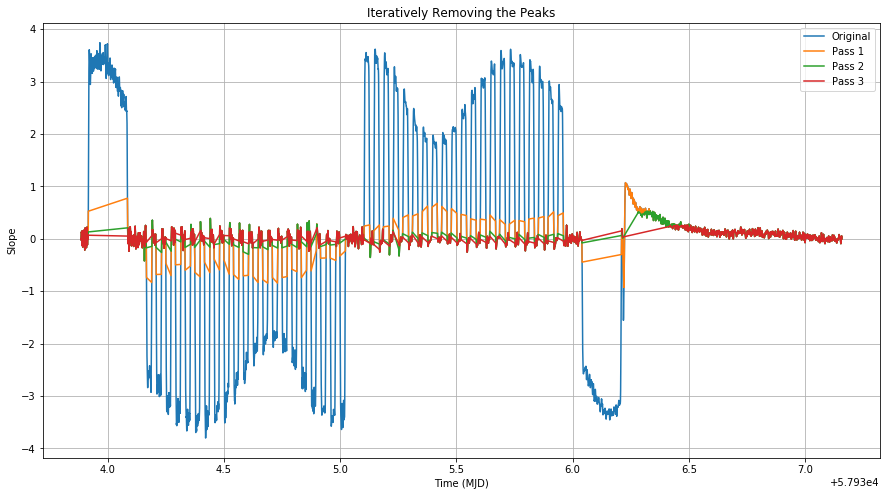

In [4]:
# Removing Sloped Regions of the Input

n = 3
smear = 50
sigma = 0

maxx = max(np.abs(dxdt))
mask = np.where(np.abs(dxdt) > maxx/3, 1, 0)
plt.plot(t.mjd[:-1], dxdt, label='Original')

i = 1
while maxx > n*sigma:
    
    # Remove leftover peaks left/right of sloped region
    for count in range(smear):
        mask = mask | np.roll(mask, 1)
        mask = mask | np.roll(mask, -1)
    
    noiseIndices = np.nonzero(1 - mask)
    plt.plot(t.mjd[noiseIndices], dxdt[noiseIndices], label='Pass ' + str(i))
    maxx = max(np.abs(dxdt[noiseIndices]))
    halfMax = maxx/2
    sigma = np.std(dxdt[noiseIndices])
    mask = np.where(np.abs(dxdt) > halfMax, 1, 0)
    i += 1

plt.grid(which='both')
plt.xlabel('Time (MJD)')
plt.ylabel('Slope')
plt.title('Iteratively Removing the Peaks')
plt.legend()
plt.show()

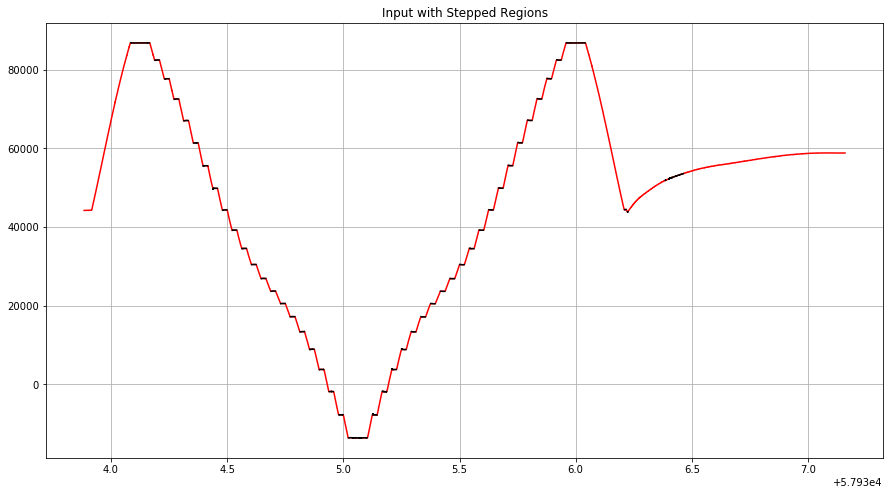

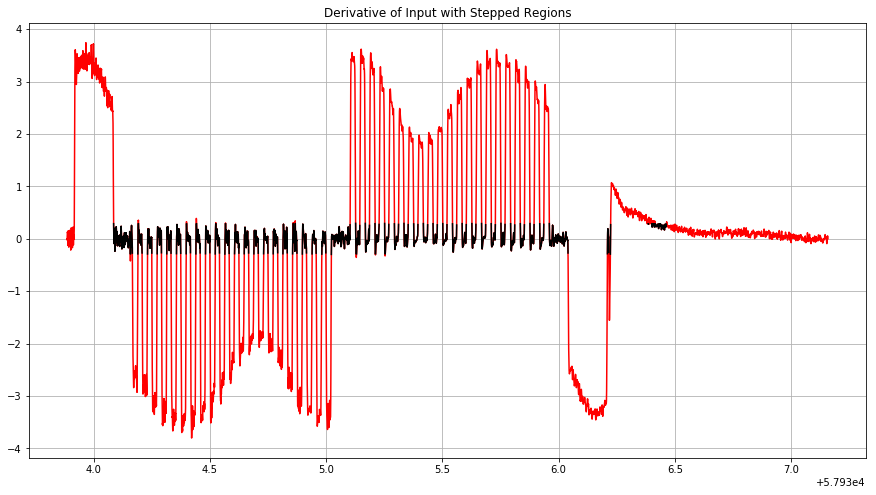

In [5]:
# Grabbing 'hold' Regions of the Input

tolerance = n*sigma
# tolerance = 0.25 # Tolerance Overide the n*sigma isnt working
zeroRegions = np.where(np.abs(dxdt) < tolerance)[0]
zeroPoints = zeroRegions[np.where(np.diff(zeroRegions) != 1)[0]]
oneRegions = np.where(np.abs(dxdt) > tolerance)[0]
onePoints = oneRegions[np.where(np.diff(oneRegions) != 1)[0]]

if zeroPoints[0] < onePoints[0]:
    zeroPoints = zeroPoints[1:]
if onePoints[-1] > zeroPoints[-1]:
    onePoints = onePoints[:-1]

regions = zip(onePoints, zeroPoints)

plt.plot(t.mjd, x, 'r')
plt.grid(which='both')
for region in regions:
    plt.plot(t[region[0]:region[1]].mjd, x[region[0]:region[1]], 'k')
plt.title('Input with Stepped Regions')

plt.figure()
plt.plot(t.mjd[:-1], dxdt, 'r')
for region in regions:
    plt.plot(t[region[0]:region[1]].mjd, dxdt[region[0]:region[1]], 'k')
plt.title('Derivative of Input with Stepped Regions')
plt.grid(which='both')
plt.show()

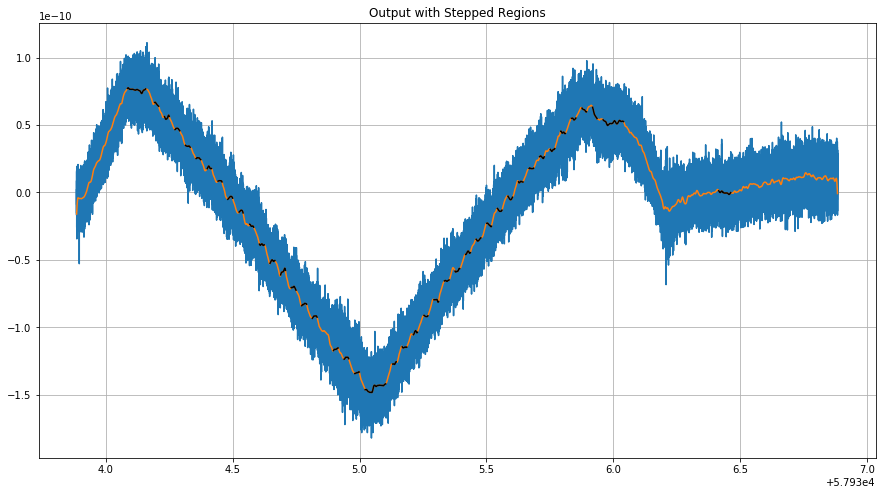

In [6]:
# Converting to Time Axis of Output
inputSet = []
outputSet = []
timeRegions = []
sumLengths = 0

for region in regions:
    tempVal = np.where(np.logical_and(t2.mjd > t[region[0]].mjd, t2.mjd < t[region[1]].mjd))[0]
    sumLengths += len(tempVal)

avgLength = sumLengths/len(regions)

for region in regions:
    tempVal = np.where(np.logical_and(t2.mjd > t[region[0]].mjd, t2.mjd < t[region[1]].mjd))[0]
    if len(tempVal) > avgLength/2:
        try:
            timeRegions.append([tempVal[0], tempVal[-1]])
            inputSet.append((x[region[0]:region[1]]).mean())
        except:
            pass

plt.plot(t2.mjd, origx2)
plt.plot(t2.mjd, x2)
resultingData = []
for region in timeRegions:
    regionResult = x2[region[0]:region[1]]
    resultingData.append(regionResult)
    outputSet.append(regionResult.mean())
    plt.plot(t2[region[0]:region[1]].mjd, regionResult, 'k')
plt.grid(which='both')
plt.title('Output with Stepped Regions')
plt.show()

In [7]:
# Removing Abnormally/Incorrect short/long times

spans = []
for region in timeRegions:
    spans.append(np.diff(t2[region])[0])

spans = [int(span.sec) for span in spans]
dataSets = zip(spans, resultingData)

indices = []
slopeSum = 0
lenSum = 0
for data in dataSets:
    responseTimes = np.linspace(0, data[0], len(data[1]))
    slope, intercept, r_value, p_value, std_err = stats.linregress(responseTimes,data[1])
    slopeSum += slope
    lenSum += len(data[1])

avgSlope = slopeSum/len(resultingData)
avgLen = lenSum/len(resultingData)

for data in dataSets:
    responseTimes = np.linspace(0, data[0], len(data[1]))
    slope, intercept, r_value, p_value, std_err = stats.linregress(responseTimes,data[1])
    # Could add removal of Sloped Lines here
    if (len(data[1]) > avgLen*2) or (len(data[1]) < avgLen/2):
        try:
            indices.append(dataSets.index(data))
        except:
            pass

# Remove this for unfiltered results
for index in reversed(indices):
    del inputSet[index]
    del outputSet[index]
    del timeRegions[index]
    del resultingData[index]

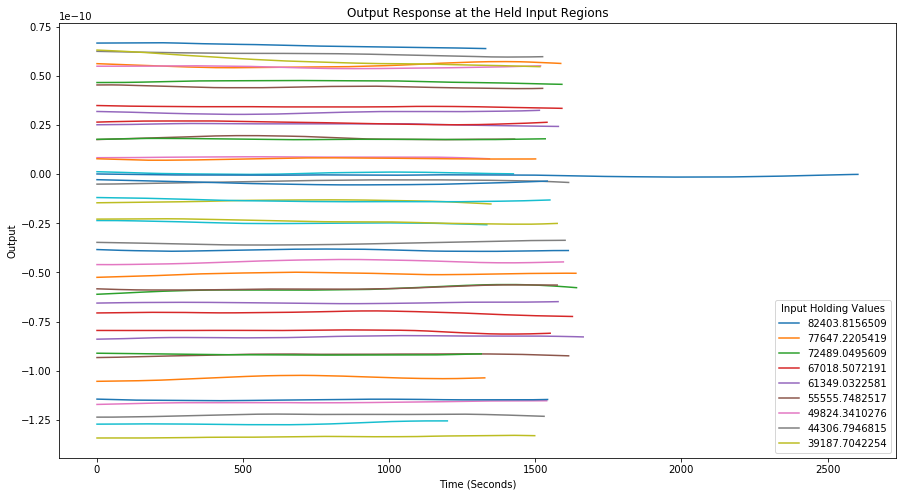

In [8]:
# Plotting each Region of Data

spans = []
for region in timeRegions:
    spans.append(np.diff(t2[region])[0])
spans = [int(span.sec) for span in spans]
dataSets = zip(spans, resultingData)

longestTimes = []
for data in dataSets:
    responseTimes = np.linspace(0, data[0], len(data[1]))
    if len(responseTimes) > len(longestTimes):
        longestTimes = responseTimes
    plt.plot(responseTimes, data[1])

if len(inputSet) > 10:
    plt.legend(inputSet[0:9], title='Input Holding Values')
else:
    plt.legend(inputSet, title='Input Holding Values')
plt.xlabel('Time (Seconds)')
plt.ylabel('Output')
plt.title('Output Response at the Held Input Regions')
plt.show()

In [9]:
# Creating csv File of Transient Results

resultsDF = pd.DataFrame(resultingData)
resultsDF = resultsDF.transpose()
resultsDF = pd.concat([pd.DataFrame(longestTimes), resultsDF], axis=1)
resultsDF.columns = ['Time (Sec) / Input Values'] + inputSet
resultsDF.to_csv('TransientResponses.csv', index=False)

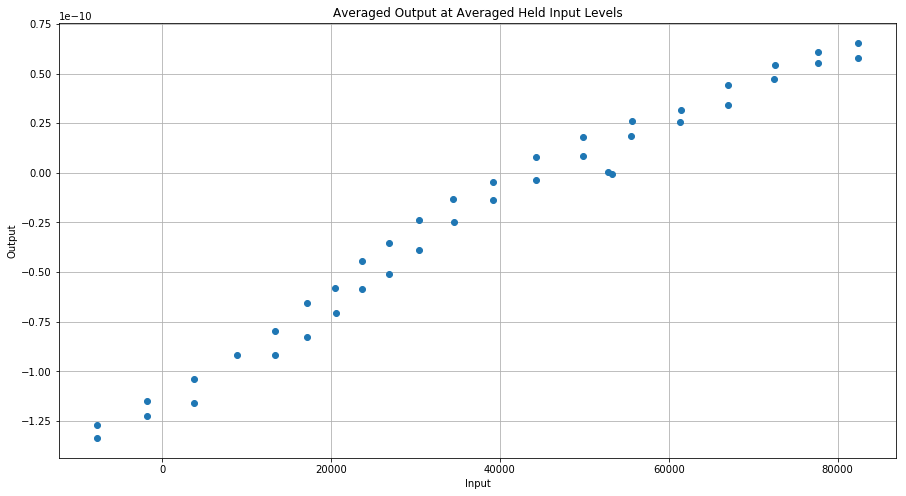

In [10]:
# Plotting Averaged Results

inputSet = [i for i in inputSet if outputSet[inputSet.index(i)] != 0]
outputSet = [i for i in outputSet if i != 0]
plt.plot(inputSet, outputSet, 'o')
plt.grid(which='both')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Averaged Output at Averaged Held Input Levels')
plt.show()

In [11]:
# Creating csv File of Results

results = zip(inputSet, outputSet)
resultsDF = pd.DataFrame(results)
resultsDF.columns = ['Avg Input Hold Value', 'Avg Output']
resultsDF.to_csv('AveragedResponse.csv', index=False, header=False)